# IBM Applied Data Science Capstone Course by Coursera

## Exploring venues in Mumbai, India using Foursquare and Zomato API

<hr>

### Dataset Resources - 

Zomato restaurant in Mumbai- https://www.kaggle.com/srivpuneet16/zomato-mumbai-restaurant-analysis?select=zomato_res_final.csv<br>
Neighbouthoods in Mumbai - https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai<br>
Foursquare API - https://developers.zomato.com/api

### Table of Contents
1. Importing libraries
2. Scrap data from Wikipedia page into a DataFrame
3. Create a map of Mumbai with neighborhoods superimposed on top using Folium map
4. Use the Foursquare API to explore venues in the neighborhoods
5. Analyze venues in the neighborhoods
6. Using Zomato dataset for finding extra features
7. Merging Data obtained from 2 APIs - foursquare API , Zomato API
8. Predicting Rating of Restaurant

## 1.Importing libraries

In [1]:
import numpy as np
import pandas as pd
import json

import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
print('Libraries imported')

Libraries imported


## 2. Scrap data from Wikipedia page into a DataFrame

In [3]:
# send the GET request
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
read_table = pd.read_html(url,header=[0])
mumbai_df = read_table[0]
print(mumbai_df.shape)
mumbai_df.head(5)

(93, 4)


Area                 Location   Latitude  Longitude
0            Amboli  Andheri,Western Suburbs  19.129300  72.843400
1  Chakala, Andheri          Western Suburbs  19.111388  72.860833
2        D.N. Nagar  Andheri,Western Suburbs  19.124085  72.831373
3    Four Bungalows  Andheri,Western Suburbs  19.124714  72.827210
4       Lokhandwala  Andheri,Western Suburbs  19.130815  72.829270

There are 93 Neighbourhoods in Mumbai,India.Data is extracted along with Latitude & Longitude

## 3. Create a map of Mumbai with neighborhoods superimposed on top using Folium map

The geograpical coordinate of Mumbai, India -  19.0760, 72.8777.

In [4]:
latitude = 19.099
longitude = 72.8777

# create map of Bangalore using latitude and longitude values
map_kl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(mumbai_df['Latitude'], mumbai_df['Longitude'], mumbai_df['Area']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_kl)  
    
map_kl

In [5]:
# save the map as HTML file
map_kl.save('map_kl.html')

## 4. Use the Foursquare API to explore venues in the neighborhoods

In [6]:
CLIENT_ID = 'YUPMBPELOUHQUDM0IQPEB3GTDASDEFXF1B5YFGXJPQBYAOTN' # your Foursquare ID
CLIENT_SECRET = 'EWU0YQLYAWDODBK1HPVFFLW54IHULILTXG0RLWDSZDROYBA4' # your Foursquare Secret
VERSION = '20203006' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YUPMBPELOUHQUDM0IQPEB3GTDASDEFXF1B5YFGXJPQBYAOTN
CLIENT_SECRET:EWU0YQLYAWDODBK1HPVFFLW54IHULILTXG0RLWDSZDROYBA4


#### Get the top 50 venues that are in Toronto within a radius of 2000 meters

In [ ]:
radius = 2000
LIMIT = 50

venues = []

for lat, lng, neighborhood in zip(mumbai_df['Latitude'], mumbai_df['Longitude'], mumbai_df['Area']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT)
    #print(url)
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
  
    #return only relevant information for each nearby venue
    for i in results:
        venue_id = i['venue']['id']
        names = i['venue']['name']
        venue_lat = i['venue']['location']['lat']
        venue_long = i['venue']['location']['lng']
        venue_category = i['venue']['categories'][0]['name']
        venues.append((
            neighborhood,lat, lng,venue_id,names,venue_lat,venue_long, venue_category))

In [ ]:
venues_df = pd.DataFrame(venues)
# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'venue_id','VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

In [ ]:
#Convert Foursquare API data to new csv for further use
venues_df.to_csv('foursquare_api_4000_venues.csv', index=True)

## 5. Analyze venues in the neighborhoods

In [7]:
## List of Categories
foursquare_api = pd.read_csv('foursquare_api_4000_venues.csv')
foursquare_api.drop(columns={'Unnamed: 0'},inplace=True)
foursquare_api.head(10)

Neighborhood  Latitude  Longitude                  venue_id  \
0       Amboli   19.1293    72.8434  5174e2be498e39cf0d1c20cb   
1       Amboli   19.1293    72.8434  4b0587e2f964a52095a522e3   
2       Amboli   19.1293    72.8434  55fc3615498e141bd45da525   
3       Amboli   19.1293    72.8434  51fa1f52ccdae6540ad807b4   
4       Amboli   19.1293    72.8434  4e4eb3c68877402b06b92160   
5       Amboli   19.1293    72.8434  52b3fe27498e991e4fe996cb   
6       Amboli   19.1293    72.8434  4cc1d37c3d7fa1cd0de39a5f   
7       Amboli   19.1293    72.8434  56433c85498ee4d7ac3bca83   
8       Amboli   19.1293    72.8434  4b0587d6f964a520bca322e3   
9       Amboli   19.1293    72.8434  4f4e4c34e4b027c8742327cf   

                    VenueName  VenueLatitude  VenueLongitude  \
0            Shawarma Factory      19.124591       72.840398   
1           Merwans Cake shop      19.119300       72.845418   
2  Jaffer Bhai's Delhi Darbar      19.137714       72.845909   
3      Hard Rock Cafe Andheri      19.135995       72.835335   
4            5 Spice , Bandra      19.130421       72.847206   
5               Pizza Express      19.131893       72.834668   
6                Joey's Pizza      19.126762       72.830001   
7            Doolally Taproom      19.135917       72.833094   
8              Mainland China      19.140391       72.838033   
9             The Little Door      19.139265       72.833180   

         VenueCategory  
0   Falafel Restaurant  
1               Bakery  
2   Mughlai Restaurant  
3  American Restaurant  
4   Chinese Restaurant  
5          Pizza Place  
6          Pizza Place  
7              Brewery  
8   Chinese Restaurant  
9                  Pub

In [8]:
df_cate = foursquare_api.VenueCategory.value_counts().reset_index()
df_cate.rename(columns={'index':'Category','VenueCategory':'Venue Category count'},inplace=True)
df_cate.head()

Category  Venue Category count
0     Indian Restaurant                   537
1                  Café                   195
2        Ice Cream Shop                   167
3  Fast Food Restaurant                   148
4           Coffee Shop                   140

### Category wise distributions of venues

In [9]:
df_table = df_cate.copy()
df_table.loc[df_table['Venue Category count'] < 80, 'Category'] = 'Other categories' # Represent only large countries

fig = px.pie(df_table, 
             values='Venue Category count',
             names='Category', 
             title='Category wise distributions of venues',
             color_discrete_sequence=px.colors.sequential.RdBu,
             labels={'Category':'Category','Venue Category count':'Counts'},
             hole=.4,
             template='plotly_dark',
             )
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

As we can see food outlet categories have more distributions than any other categories,we will collect all types of food outlet venues and restaurants for analysis. 

In [10]:
#defining list of venue categories for finding all types of Restaurants
list = ['Indian Restaurant', 'Café','Fast Food Restaurant','Bakery', 'Ice Cream Shop','Pizza Place','Chinese Restaurant','Restaurant','Falafel Restaurant','Sandwich Place', 'Breakfast Spot', 'Chinese Restaurant',
       'American Restaurant', 'Diner','Snack Place', 'Seafood Restaurant', 'Maharashtrian Restaurant',
       'Vegetarian / Vegan Restaurant','Asian Restaurant','Hotel', 'Food','German Restaurant', 'Modern European Restaurant', 'Salad Place','French Restaurant',
       'Hawaiian Restaurant', 'Tex-Mex Restaurant','Dhaba','North Indian Restaurant','Dim Sum Restaurant', 'Irani Cafe',
        'Mexican Restaurant', 'Mughlai Restaurant','Afghan Restaurant','Middle Eastern Restaurant',
       'Gujarati Restaurant','Multicuisine Indian Restaurant','South Indian Restaurant', 'Thai Restaurant', 'Goan Restaurant','Multicuisine Indian Restaurant']

rest_df = foursquare_api[foursquare_api['VenueCategory'].isin(list)]
print(rest_df.shape)

(2037, 8)


In [11]:
rest_counts = rest_df.Neighborhood.value_counts().reset_index()
rest_counts.rename(columns={'Neighborhood':'Restaurants','index':'Neighborhood'},inplace=True)

df_counts = foursquare_api.set_index('Neighborhood').join(rest_counts.set_index('Neighborhood'))
df_counts.reset_index(inplace=True)
df_counts.head()

Neighborhood   Latitude  Longitude                  venue_id  \
0  Aarey Milk Colony  19.148493  72.881756  4b0587d1f964a520e6a222e3   
1  Aarey Milk Colony  19.148493  72.881756  4c23e5cddb519521f2d92b3a   
2  Aarey Milk Colony  19.148493  72.881756  4d6768c0709bb60ce269a914   
3  Aarey Milk Colony  19.148493  72.881756  4dd3c9be7d8b6704c7ad0b84   
4  Aarey Milk Colony  19.148493  72.881756  5124d434e4b04c1a0d33958b   

                 VenueName  VenueLatitude  VenueLongitude  \
0                Film City      19.160960       72.886177   
1             Supremo Club      19.135436       72.873076   
2   Saffron Eatery And Bar      19.135743       72.873595   
3  Aarey Garden Restaurant      19.155514       72.878236   
4                    BeFit      19.153570       72.885704   

          VenueCategory  Restaurants  
0           Event Space          7.0  
1                   Gym          7.0  
2            Restaurant          7.0  
3     Indian Restaurant          7.0  
4  Gym / Fitness Center          7.0

### Bubble map using Folium 
Size of circular marker represent count of restaurants in that neighborhood

In [12]:
latitude = 19.0760
longitude = 72.8777

# create map of Bangalore using latitude and longitude values
map_kl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood,count in zip(df_counts['Latitude'], df_counts['Longitude'], df_counts['Neighborhood'],df_counts['Restaurants']):
    label = '{}-Restaurants - {}'.format(neighborhood,count)
    folium.CircleMarker(
        [lat, lng],
        radius=count/3,
        popup=label,
        color='3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5).add_to(map_kl)  
    
map_kl

## 6.Using Zomato dataset for finding extra features

In [13]:
zomato_df = pd.read_csv('zomato_res_final.csv')
zomato_df.drop(columns={'Call','View_Menu','Additional_outlet_count','Features','Restaurant_Type','Restaurant_Type','Delivery_Time(mins)','Min_Order(Rs.)'},inplace=True)
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6526 entries, 0 to 6525
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cost_for_two(Rs.)           6526 non-null   int64  
 1   Cuisines                    6525 non-null   object 
 2   Home_Delivery               6526 non-null   bool   
 3   Operational_hours           6518 non-null   object 
 4   Restaurant_Location         6511 non-null   object 
 5   Restaurant_Name             6526 non-null   object 
 6   Rating                      6526 non-null   float64
 7   Votes                       6526 non-null   float64
 8   Rating_Category             6526 non-null   object 
 9   Operational_after_Midnight  6526 non-null   bool   
 10  Cuisine_count               6526 non-null   int64  
 11  Feature_Count               6526 non-null   int64  
 12  Res_Type_Count              6526 non-null   int64  
 13  Competitors_in_Location     6511 

In [14]:
zomato_df['Home_Delivery'] = zomato_df['Home_Delivery'].astype('int')
zomato_df['Operational_after_Midnight'] = zomato_df['Operational_after_Midnight'].astype('int')
zomato_df = zomato_df.loc[zomato_df['Cost_for_two(Rs.)'] < 10000]
zomato_df.drop(columns={'Home_Delivery'},inplace=True)
zomato_df.replace({'Rating_Category' : {'Not rated': 0, 'Poor': 1, 'Average': 2, 'Good': 3, 'Very Good': 4, 'Excellent' : 5}}, inplace = True)
zomato_df.head()

Cost_for_two(Rs.)                                       Cuisines  \
0               1500    Finger Food, Continental, European, Italian   
1                800                                          Pizza   
2               2500                                        Seafood   
3               1800                       Finger Food, Continental   
4                450  North Indian, Street Food, Fast Food, Chinese   

                                Operational_hours    Restaurant_Location  \
0                          12noon – 1am (Mon-Sun)  Kamala Mills Compound   
1                        11am – 12:30AM (Mon-Sun)             Malad West   
2  Closed (Mon),12noon – 3pm, 7pm – 12midnight...            Bandra West   
3                          12noon – 1am (Mon-Sun)            Lower Parel   
4           12noon – 4pm, 7pm – 11:45pm (Mon-Sun)                  Vashi   

      Restaurant_Name  Rating   Votes  Rating_Category  \
0  Lord of the Drinks     4.9  1326.0                5   
1        Joey's Pizza     4.6  5974.0                5   
2             Bastian     4.5  1438.0                5   
3             Tamasha     4.9  3275.0                5   
4    Bhagat Tarachand     4.1  1422.0                4   

   Operational_after_Midnight  Cuisine_count  Feature_Count  Res_Type_Count  \
0                           1              4              2               2   
1                           1              1              2               1   
2                           0              1              2               2   
3                           1              2              3               2   
4                           0              4              1               1   

   Competitors_in_Location      Score  
0                     19.0  48.000806  
1                    209.0  71.950295  
2                    241.0  43.160370  
3                    125.0  59.778427  
4                    116.0  37.546442

## 7.Merging Data obtained from 2 APIs - foursquare API , Zomato API

In [15]:
print(zomato_df.shape)
print(foursquare_api.shape)

(6524, 14)
(3967, 8)


In [16]:
zomato_df['Restaurant_Name'] = zomato_df['Restaurant_Name'].str.lower()
foursquare_api['VenueName'] = foursquare_api['VenueName'].str.lower()

In [17]:
merged = pd.merge(zomato_df, foursquare_api,left_on='Restaurant_Name', right_on='VenueName')
merged.drop(columns='VenueName',inplace=True)
print(merged.shape)
merged.head()

(1498, 21)


Cost_for_two(Rs.) Cuisines         Operational_hours Restaurant_Location  \
0                800    Pizza  11am – 12:30AM (Mon-Sun)          Malad West   
1                800    Pizza  11am – 12:30AM (Mon-Sun)          Malad West   
2                800    Pizza  11am – 12:30AM (Mon-Sun)          Malad West   
3                800    Pizza  11am – 12:30AM (Mon-Sun)          Malad West   
4                800    Pizza  11am – 12:30AM (Mon-Sun)          Malad West   

  Restaurant_Name  Rating   Votes  Rating_Category  \
0    joey's pizza     4.6  5974.0                5   
1    joey's pizza     4.6  5974.0                5   
2    joey's pizza     4.6  5974.0                5   
3    joey's pizza     4.6  5974.0                5   
4    joey's pizza     4.6  5974.0                5   

   Operational_after_Midnight  Cuisine_count  ...  Res_Type_Count  \
0                           1              1  ...               1   
1                           1              1  ...               1   
2                           1              1  ...               1   
3                           1              1  ...               1   
4                           1              1  ...               1   

   Competitors_in_Location      Score     Neighborhood   Latitude  Longitude  \
0                    209.0  71.950295           Amboli  19.129300  72.843400   
1                    209.0  71.950295       D.N. Nagar  19.124085  72.831373   
2                    209.0  71.950295   Four Bungalows  19.124714  72.827210   
3                    209.0  71.950295      Lokhandwala  19.130815  72.829270   
4                    209.0  71.950295  Seven Bungalows  19.129052  72.817018   

                   venue_id VenueLatitude  VenueLongitude  VenueCategory  
0  4cc1d37c3d7fa1cd0de39a5f     19.126762       72.830001    Pizza Place  
1  4cc1d37c3d7fa1cd0de39a5f     19.126762       72.830001    Pizza Place  
2  4cc1d37c3d7fa1cd0de39a5f     19.126762       72.830001    Pizza Place  
3  4cc1d37c3d7fa1cd0de39a5f     19.126762       72.830001    Pizza Place  
4  4cc1d37c3d7fa1cd0de39a5f     19.126762       72.830001    Pizza Place  

[5 rows x 21 columns]

In [18]:
merged.columns

Index(['Cost_for_two(Rs.)', 'Cuisines', 'Operational_hours',
       'Restaurant_Location', 'Restaurant_Name', 'Rating', 'Votes',
       'Rating_Category', 'Operational_after_Midnight', 'Cuisine_count',
       'Feature_Count', 'Res_Type_Count', 'Competitors_in_Location', 'Score',
       'Neighborhood', 'Latitude', 'Longitude', 'venue_id', 'VenueLatitude',
       'VenueLongitude', 'VenueCategory'],
      dtype='object')

### Analyzing Data

In [19]:
fig = px.pie(zomato_df,
             values='Rating', 
             names='Rating_Category', 
             title='Rating distributions',
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

### average prices of all venues for 2 persons using a scatter plot

In [20]:
avg_price = merged.groupby('Neighborhood').mean().reset_index()
fig = px.scatter(avg_price,x='Neighborhood',y='Cost_for_two(Rs.)',title='average prices of all venues using a scatter plot',size = 'Cost_for_two(Rs.)',
                color = 'Cost_for_two(Rs.)')
fig.update_layout(
    autosize=False , width=1000, height=650,
    margin=dict(l=50,r=50,b=100,t=100,pad=4))

### Frequency Distribution of  Restaurants in various Neighborhoods

In [21]:
rest_df = zomato_df.Restaurant_Location.value_counts().reset_index()
rest_df.rename(columns={'index':'Neighborhood','Restaurant_Location':'Restaurants'},inplace=True)
zomato_df.drop(columns="Rating_Category",inplace=True)
px.bar(rest_df,x='Neighborhood',y='Restaurants')

## 8. Predicting Rating of Restaurant

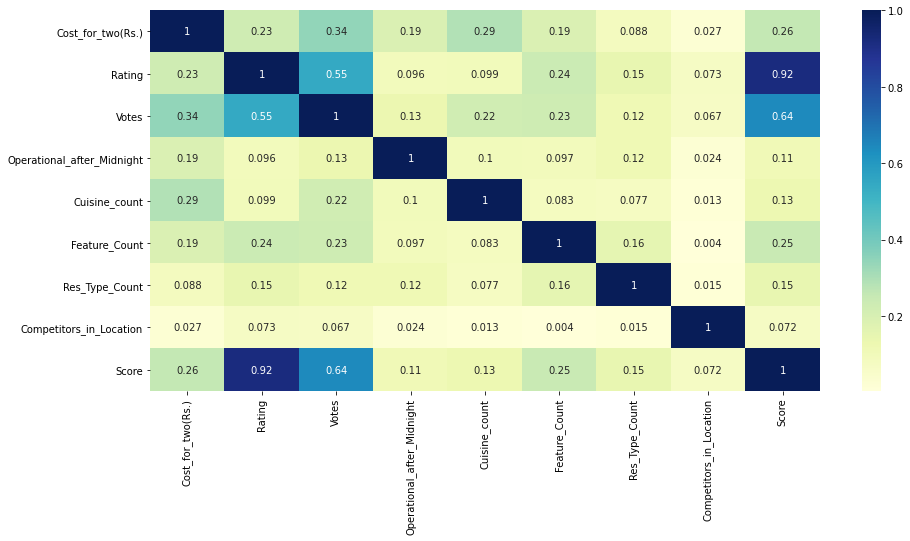

In [22]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(15,7))
cor = zomato_df.corr(method='kendall')
sns.heatmap(cor, annot=True,cmap="YlGnBu")
plt.show()

From the above Heat map, we can see that the Target Value (Rating) is correlated well with the 'votes', 'feature_count' and 'cost_for_two', with correlation values being 0.51, 0.31 and 0.33 respectively.

### Selection of features & preprocessing

In [23]:
x = zomato_df[['Feature_Count','Cost_for_two(Rs.)','Cuisine_count','Votes','Operational_after_Midnight','Score']].values #Features
y = zomato_df['Rating'].values

In [24]:
from sklearn import preprocessing
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

In [25]:
lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)
y[0:5]

array([29, 26, 25, 29, 21], dtype=int64)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.2, random_state = 1) # Splitting the Data into Training and Test with test size as 20%

### Decision Tree Classifier Model

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree_gini = DecisionTreeClassifier(criterion = "gini", random_state = 2, max_depth=8, min_samples_leaf=10)
dtree_gini.fit(X_train, y_train)
dtree_gini_pred = dtree_gini.predict(X_test)
print('Decision Tree Accuracy:', accuracy_score(y_test, dtree_gini_pred)*100)

Decision Tree Accuracy: 85.6704980842912


### K-Neighbors Classifier model

In [28]:
from sklearn import neighbors
knn=neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('K Nearest Neighbor Accuracy:', accuracy_score(y_test, knn_pred)*100)

K Nearest Neighbor Accuracy: 72.33716475095785


### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, oob_score=True)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy:', accuracy*100)
print('Random Forest Out-of-bag score estimate:', rf.oob_score_*100)

Random Forest Accuracy: 89.50191570881226
Random Forest Out-of-bag score estimate: 88.6951523280322


### SVM

In [30]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',gamma='auto')
clf.fit(X_train, y_train) 
svm_pred = clf.predict(X_test)
print('SVM Accuracy:', accuracy_score(y_test, svm_pred)*100)

SVM Accuracy: 78.16091954022988


### Decision Tree Regressor Model

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(X_train, y_train)
DTree_pred = DTree.predict(X_test)
print('Decision Tree Regressor Accuracy:', accuracy_score(y_test, DTree_pred)*100)

Decision Tree Regressor Accuracy: 96.47509578544062


After applying Several Regression models such as DecisionTreeRegressor, DecisionTreeClassifier, RandomForestClassifier and SVM, DecisionTreeRegressor has yielded us Best Accuracy compared to all the other models which is of 96.09%.

In [33]:
comparision = pd.DataFrame(columns={'Actual','Predicted'})
comparision['Actual'] = np.asarray(y_test/5)
comparision['Predicted'] = np.asarray(DTree_pred/5)
comparision.head(10)

Actual  Predicted
0     2.8        2.8
1     4.4        4.2
2     3.2        3.2
3     2.6        2.6
4     2.4        2.4
5     3.0        3.0
6     4.6        4.6
7     2.2        2.2
8     3.0        3.0
9     3.4        3.4